# GORG classifier

We developed the GORG (Global Oceans Reference Genomes) classifier to recruit reads to a database made up of single cell genomes and assign taxonomy and function to reads. 

We have already gone ahead and recruited the same reads from metagenomes that we used this morning to the GORG database, [described here](https://www.sciencedirect.com/science/article/pii/S0092867419312735).

The outputs from the GORG-classifier_setup notebook are in this folder storage/lesson_analyses/gorg-classifier

Lets take a look in that folder now.

In [2]:
!ls /mnt/storage/lesson_analyses/gorg-classifier

annotations  logs  summaries  work


Let's first examine the summaries folder.

In [3]:
!ls /mnt/storage/lesson_analyses/gorg-classifier/summaries

SRR5720233_summary.txt	SRR5720278_summary.txt	SRR5720332_summary.txt
SRR5720235_summary.txt	SRR5720283_summary.txt	SRR5720337_summary.txt
SRR5720238_summary.txt	SRR5720286_summary.txt	SRR5720338_summary.txt
SRR5720251_summary.txt	SRR5720307_summary.txt	SRR5720342_summary.txt
SRR5720256_summary.txt	SRR5720321_summary.txt	SRR6507279_summary.txt
SRR5720260_summary.txt	SRR5720322_summary.txt
SRR5720262_summary.txt	SRR5720327_summary.txt


There is a summary for each metagenome run through the GORG-classifier.  These are short files meant to give a very quick assessment of how the GORG-classifier did in assigning reads to taxonomic and functional categories.

The metagenome SRR6507279 is from the same location and timepoint the SAG plate we've been looking at in previous lessons, AG-910. Let's look at this one first.  

Note that we are recruiting to a subset of 5,536 SAGs from the GORG-tropics dataset and not just the AG-910 plate that we have been using in previous lessons. The summaries file produces a nice short text file that is only 12 lines long so by increasing the number of lines that we use in the head command we can look at the entire file at once.

In [4]:
! head /mnt/storage/lesson_analyses/gorg-classifier/summaries/SRR6507279_summary.txt -n 15

Sequences:  999999
Taxonomy assignments
 Superkingdom: 770984 (77.10%)
 Phylum: 769883 (76.99%)
 Class: 685697 (68.57%)
 Order: 601941 (60.19%)
 Family: 585649 (58.56%)
 Genus: 118459 (11.85%)
 Species: 456 (0.05%)
Functional assignments
 Function: 771149 (77.11%)
 Non-hypothetical: 613799 (61.38%)
 EC: 441026 (44.10%)


Now lets look at the annotations file to see what we have in there.

Wow! we are recruiting nearly 77% of all of the reads just to gene sequences and most of these reads (61% of the total) have functional annotations to Non-hypothetical genes. 

If you recall from this morning, we were only able to recruit a maximum of around 30% of metagenomic reads to SAGs from plate AG-910.  Expanding the reference database to GORG-Tropics, which uses a curated collection of 5,536 SAGs from the 12,715 cell collection, allowed us to recruit a much greater number of metagenomic reads overall.  

The real meat of the results are in the **annotations** output directory.  Let's explore.

In [5]:
! ls /mnt/storage/lesson_analyses/gorg-classifier/annotations/

SRR5720233_annotated.txt.gz  SRR5720307_annotated.txt.gz
SRR5720235_annotated.txt.gz  SRR5720321_annotated.txt.gz
SRR5720238_annotated.txt.gz  SRR5720322_annotated.txt.gz
SRR5720251_annotated.txt.gz  SRR5720327_annotated.txt.gz
SRR5720256_annotated.txt.gz  SRR5720332_annotated.txt.gz
SRR5720260_annotated.txt.gz  SRR5720337_annotated.txt.gz
SRR5720262_annotated.txt.gz  SRR5720338_annotated.txt.gz
SRR5720278_annotated.txt.gz  SRR5720342_annotated.txt.gz
SRR5720283_annotated.txt.gz  SRR6507279_annotated.txt.gz
SRR5720286_annotated.txt.gz


We can look at the first 10 rows of these compressed files like so:

In [6]:
!zcat /mnt/storage/lesson_analyses/gorg-classifier/annotations/SRR5720233_annotated.txt.gz | head -n10

status	sequence_id	taxonomy_id	length	taxonomy_ids_lca	sequence_ids_lca	protein_sequence	taxonomic_lineage	prokka_gene	prokka_EC_number	prokka_product	swissprot_gene	swissprot_EC_number	swissprot_product	swissprot_eggNOG	swissprot_KO	swissprot_Pfam	swissprot_CAZy	swissprot_TIGRFAMs
U	SRR5720233.7	0
C	SRR5720233.18	1218	235	1218,	AG-349-A05_NODE_1;26176;27333,AG-349-A23_NODE_8;30175;31335,AG-349-C13_NODE_22;3335;4492,AG-349-D14_NODE_3;21528;22685,AG-349-L19_NODE_37;4434;5591,AG-359-B02_NODE_20;1851;3008,AG-359-M08_NODE_45;1985;3142,AG-360-I18_NODE_5;4648;5805,AG-422-A17_NODE_2;15207;16364,AG-422-I21_NODE_5;11781;12938,AG-422-K13_NODE_7;47218;48375,AG-422-M14_NODE_20;4750;5907,AG-426-L07_NODE_18;4506;5663,AG-426-L14_NODE_18;4701;5858,AG-435-M14_NODE_25;5006;6163,AG-453-A13_NODE_23;14208;15365,AG-453-F21_NODE_4;5794;6951,AG-453-N17_NODE_5;22965;24122,AG-461-P02_NODE_42;4675;5832,AG-891-D19_NODE_28;337;1494,	YLLEGLKVIASENVLLKCNIATTPAVFVPEDNLNSFTYLVMPVQVRS,	Bacteria; Cyanobacteria; NA; Syne

Alright there is a lot going on there and the formatting is a bit strange so lets go ahead and load all of our libraries and load this file into a dataframe to make it a bit easier to interpret

In [7]:
import pandas as pd
import os
import sys
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import time

# modify pandas variabls to only show 10 rows.
pd.set_option("display.max_rows", 10)

# change default figure size 
plt.rcParams["figure.figsize"] = (8,6)

# NOTE: YOU should already have this directory set up, and should currenly be in this directory if they are running this notebook
#lessondir='/home/jupyter-julia/repos/Day3PM_gorg-classifier/'
#if not os.path.exists(lessondir):
#    os.mkdir(lessondir)
    
#os.chdir(lessondir)

outdir = "./tbls/"
figdir = "./figs/"

if not os.path.exists(outdir):
    os.mkdir(outdir)
if not os.path.exists(figdir):
    os.mkdir(figdir)


annotations_file = '/mnt/storage/lesson_analyses/gorg-classifier/annotations/SRR6507279_annotated.txt.gz'

In [8]:
data=pd.read_csv(annotations_file, compression='gzip', sep='\t')
data.head()

,status,sequence_id,taxonomy_id,length,taxonomy_ids_lca,sequence_ids_lca,protein_sequence,taxonomic_lineage,prokka_gene,prokka_EC_number,prokka_product,swissprot_gene,swissprot_EC_number,swissprot_product,swissprot_eggNOG,swissprot_KO,swissprot_Pfam,swissprot_CAZy,swissprot_TIGRFAMs
0,C,SRR6507279.16,31989,84.0,"31989,","AG-430-D23_NODE_9;21445;22080,","DDLNQTFPVVALTRATI,",Bacteria; Proteobacteria; Alphaproteobacteria;...,crtA,1.14.15.9,Spheroidene monooxygenase,CRTA_RHOCB,1.14.15.9,Spheroidene monooxygenase,"ENOG4108ZIP,CENOG4111MV2",K09847,NaN,NaN,NaN
1,U,SRR6507279.25,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C,SRR6507279.30,62654,200.0,"62654,","AG-899-J15_NODE_8;60600;61463,","GHPETSAMKHALKELEFYCGQNKVKILGTYLASPLRKS,",Bacteria; Proteobacteria; Alphaproteobacteria;...,pheA_2,NaN,P-protein,PHEA_AQUAE_2,"5.4.99.5,C4.2.1.51",P-protein [Includes: Chorismate mutase (CM),"ENOG4105CQC,CCOG0077,CCOG1605",K14170,"PF01842,CPF01817,CPF00800",NaN,NaN
3,C,SRR6507279.31,1655516,134.0,"1655516,","AG-337-E15_NODE_4;84560;86134,AG-426-O10_NODE_...","TLIEKKFTTDTEKQWLRQKLLEYKVK,",Bacteria; Proteobacteria; Alphaproteobacteria;...,NaN,NaN,hypothetical protein,BAX_ECOLI_3,NaN,Protein bax,"ENOG4108UR8,CCOG2992",K03796,PF01832,GH73,NaN
4,C,SRR6507279.40,62654,202.0,"62654,","AG-359-O10_NODE_1;233253;234284,AG-891-J15_NOD...","DAINCLKPKGTMIQLGLGGDVLIPLVSVTTKELNLRGSFR,",Bacteria; Proteobacteria; Alphaproteobacteria;...,idnD,1.1.1.264,L-idonate 5-dehydrogenase (NAD(P)(+)),IDND_ECOLI,1.1.1.264,L-idonate 5-dehydrogenase (NAD(P)(+)),"ENOG4105CPQ,CCOG1063",K00098,"PF08240,CPF00107",NaN,NaN


This file contains a row for **every single read** within a metagenome.  You can imagine how these can get pretty massive, and manipulating them in a notebook could get unweildy.  For this lesson, the metagenomes we're using were subsampled to 1 million reads, so these tables are manageable.

OK there is a lot going on here lets break this down a little bit by looking at each of the important columns again
 - status: Tells us if the read was Classified (C) or Unclassified (U)
 - sequence_id: read name
 - taxonomy_id: NCBI tax_ID number. Indicates the NCBI taxonomy
 - taxonomy_ids_lca: NCBI tax_ID number of the last common ancestor if there are multiple matches. This is used to determine the taxonomic assignment
 - taxonomy_lineage: NCBI formatted taxonomy represented by the tax_ID number.
 - The rest of the columns tell us information about the protein using the Prokka annotations


### Important Note:
The taxonomic id here uses the NCBI based taxonomy and not the GTDB based taxonomy that we discussed yesterday. As a result these taxonomies are not directly compatable so it is challenging to try and get them to work together. We are in the process of updating the GORG classifier database so that the GTDB taxonomy will be available as a database as well as some other modifications to make it more user friendly, flexible, and provide a more informative output. Be on the lookout for an update to this program sometime soon

## Functional characterization of metagenomic reads.

Let's look at the functional profiles of this metagenome by taxonomic group. I am going to group this dataframe by the ```taxonomic_lineage``` and ```prokka_product``` columns.

In [9]:
# I choose to group on the lineage and the prokka_product but you can pick any columns that you want to. The count column (sequence_id)
# needs to be one of the columns that you are not grouping by but other than that it can be anything.
grouped=data[data['status']=='C'].groupby(['taxonomic_lineage', 'prokka_product'], as_index= False)['sequence_id'].count()

grouped=grouped.rename(columns={'sequence_id':'number_of_reads'})

In [10]:
# lets start by looking at the most abundant functions by taxnomic group that are in this dataset

grouped.sort_values(['number_of_reads'], inplace=True, ascending=False)
grouped.head()

,taxonomic_lineage,prokka_product,number_of_reads
15051,Bacteria; Proteobacteria; Alphaproteobacteria;...,hypothetical protein,47145
4262,Bacteria; Bacteroidetes; Flavobacteriia; Flavo...,hypothetical protein,18095
9149,Bacteria; Cyanobacteria; NA; Synechococcales; ...,hypothetical protein,17896
29146,Bacteria; Proteobacteria; Gammaproteobacteria;...,hypothetical protein,17690
20707,Bacteria; Proteobacteria; Alphaproteobacteria;...,hypothetical protein,12714


Not surprisingly the most abundant proteins are hypothetical proteins since we grouped all hypothetical proteins together in our groupby command. Lets get rid of those proteins so that we can look at the proteins that have a functional annotation and plot them.

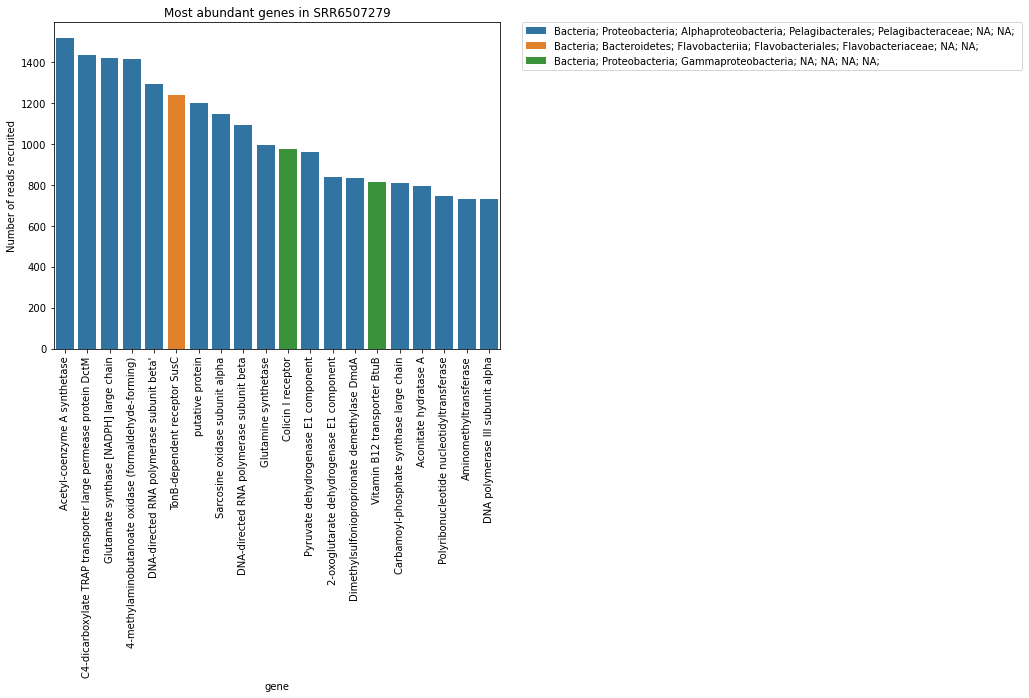

In [11]:
# select the 20 most abundant proteins that are not hypothetical proteins
sub_group=grouped[grouped['prokka_product']!= 'hypothetical protein'][:20]

# genrate the plot 
sns.barplot(data=sub_group, x='prokka_product', y='number_of_reads', hue='taxonomic_lineage', dodge=False)

# create axis labels and rotate axis
plt.xlabel('gene')
plt.ylabel('Number of reads recruited')
plt.title('Most abundant genes in SRR6507279')
plt.xticks(rotation=90)

# move legend outside of chart
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(figdir,"read_recruitment_to_most_abundant_functions.pdf"))

Most of the most abundant genes are from Pelagibacteraceae. Not too surprising, but there are a couple of genes from either Flavobacteriaceae or Gammaproteobacteria.

Let's next look at the most abundant gene functions overall regardless of taxnomic assignment:

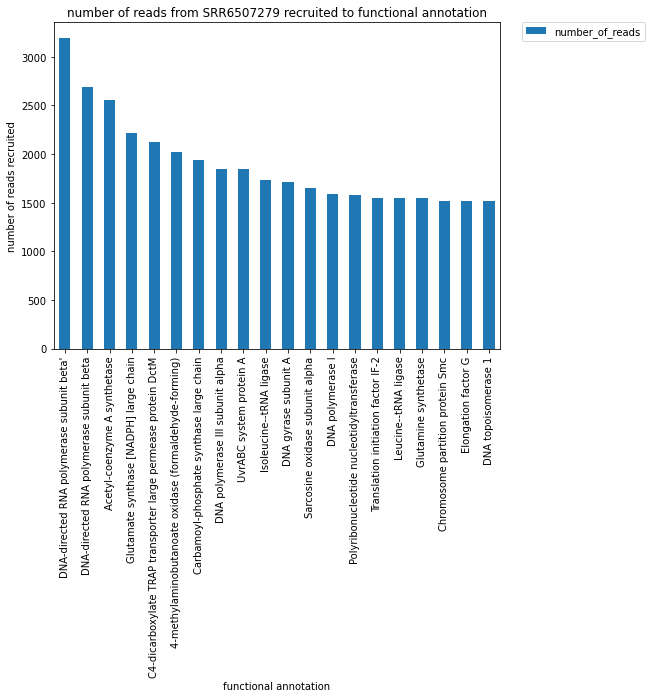

In [12]:

# group by just the functional annotation to look at functional abundance
functional_df=data[data['status']=='C'].groupby('prokka_product', as_index= False)['sequence_id'].count()

#rename the sequence_id and sort
functional_df=functional_df.rename(columns={'sequence_id':'number_of_reads'})
functional_df.sort_values(['number_of_reads'], inplace=True, ascending=False)

# extract the first 20 rows for the plot
sub_functional_df=functional_df[~functional_df['prokka_product'].isin(['hypothetical protein', 'putative protein'])][:20]

# generate the plot
sub_functional_df.plot(kind='bar', x='prokka_product', y='number_of_reads')

# generate labels
plt.xlabel('functional annotation')
plt.ylabel('number of reads recruited')
plt.title('number of reads from SRR6507279 recruited to functional annotation')

# move legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# save plot
plt.savefig(os.path.join(figdir,"most_abundant_functions_in_SRR6507279.pdf"))


Cool so it looks like DNA directed RNA polymerases are the most common genes in this metagenome. 

Note that the two most abundant genes are essentially the same thing but that one of them has an ' at the very end and the other one does not. As a result of this the computer is identifying them as two different genes. 

It looks like there most of the most common genes are involved in imformation processing (RNA transcriptin, DNA replication, tRNA ligases, DNA repair or DNA synthesis) in some way. 

## Taxonomic characterization of metagenomic reads

Next, I am curious what taxonomic lineages are represented within this metagenome, so I will group by taxonomic lineage, and count reads belowing to each.

/opt/tljh/user/envs/biopy/lib/python3.10/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


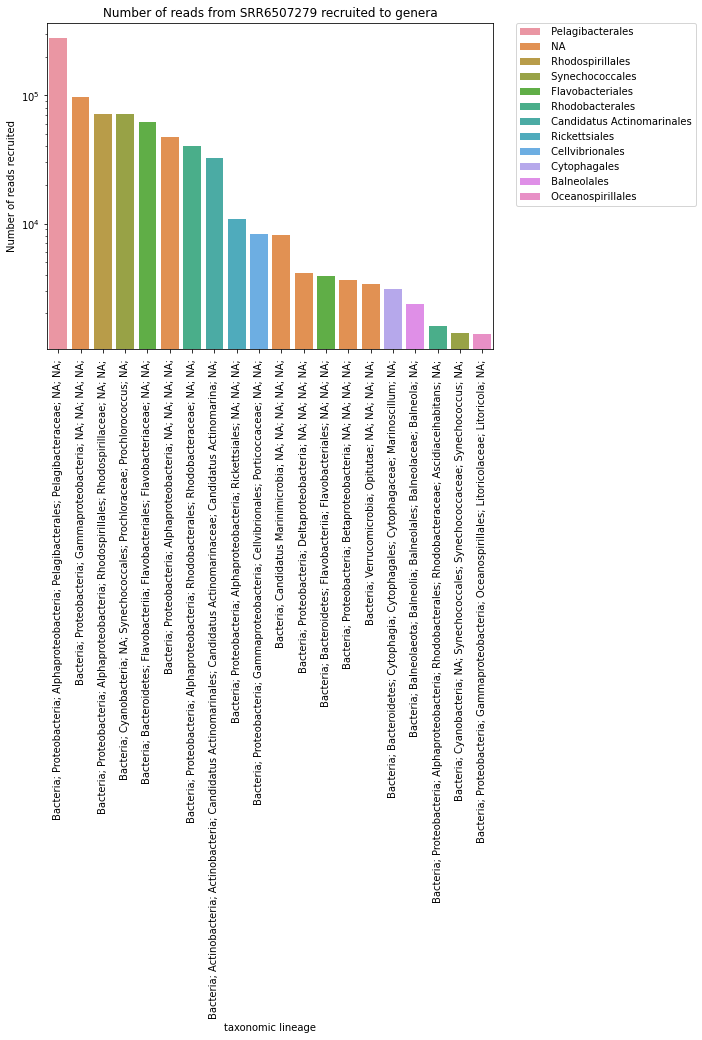

In [13]:
#group by just the taxonomic lineage to look at lineage abundance
tax_df=data[data['status']=='C'].groupby('taxonomic_lineage', as_index= False)['sequence_id'].count()

# rename the sequence id to reflect that it is the number of reads and sort high to low
tax_df=tax_df.rename(columns={'sequence_id':'number_of_reads'})
tax_df.sort_values(['number_of_reads'], inplace=True, ascending=False)

# extract the first 20 rows for the plot
sub_tax_df=tax_df[:20]
# split the classification so that we can use taxonomic levels to color the barchart
sub_tax_df[['domain', 'phyla', 'class', 'order', 'family', 'genus', 'species', '']]=sub_tax_df.taxonomic_lineage.str.split(';', expand=True)


# generate the plot. I will plot the log10 transformation of the number of reads in order to better visualize these values
ax = sns.barplot(data= sub_tax_df, x='taxonomic_lineage', y = 'number_of_reads', hue='order', dodge=False)

# create axis labels 
ax.set(xlabel = 'taxonomic lineage',
       ylabel = 'Number of reads recruited',
       title = 'Number of reads from SRR6507279 recruited to genera', 
       yscale = 'log')

# rotate x-axis labels
plt.xticks(rotation=90)


# move legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(os.path.join(figdir,"most_abundant_lineages_in_SRR6507279.pdf"))


<br>

## 30 minute coffee and coding break

During this time get some coffee and snacks if you would like. 

Additionally everyone pick a gene of interest and a taxonomic lineage of interest and determine:

For the gene: in what lineage is it most abundant?  

For the lineage: what functional genes are most abundant?  

I'll leave some space below in this notebook for you to work on this.
<br>

When we come back we will look into the distribution of different functional categories in different lineages.

## Examining the distribution of COGs within a metagenome

The annotation output files provide more than just a taxonomic assignment and prokka function. If a gene is aligned to the database, GORG-classifier provides an array of different functional characterizations.  Those include:

* prokka_gene
* prokka_EC_number
* prokka_product
* swissprot_gene
* swissprot_EC_number
* swissprot_product
* swissprot_eggNOG
* swissprot_KO
* swissprot_Pfam
* swissprot_CAZy
* swissprot_TIGRFAMs

These may look familiar to you as they are all flavors of annotaton provided in the standard SCGC SAG deliverable that Ramunas and Greg reviewed on day 1.

Next, I'm going to look into the funcitonal profiles of this metagenome using the COG IDs provided in the ```swissprot_eggNOG``` column.


To do this, I've manipulated the file ```tbls/cog-20.def.csv``` available on the [COG website](https://ftp.ncbi.nih.gov/pub/COG/COG2020/data/).  My manipulated table: ```tbls/cog-20_unambiguous.csv``` has eliminated COGs that are assigned to multiple functional categories.

In [14]:
# I generated this file from the cog-20.def.csv file that is available for download on the COG website. 
# the major difference is that I eliminated COGs that are assigned to multiple functional categories
COG_summary=pd.read_csv('tbls/cog-20_unambiguous.csv', index_col=0)
# Only keep the columns that we are interested in.
COG_summary=COG_summary[['COG_ID', 'Functional_category', 'COG_name', 'Functional category description']].copy()
COG_summary.head()

,COG_ID,Functional_category,COG_name,Functional category description
0,COG0001,H,Glutamate-1-semialdehyde aminotransferase,Coenzyme transport and metabolism
1,COG0002,E,N-acetyl-gamma-glutamylphosphate reductase,Amino acid transport and metabolism
2,COG0003,P,"Anion-transporting ATPase, ArsA/GET3 family",Inorganic ion transport and metabolism
3,COG0004,P,Ammonia channel protein AmtB,Inorganic ion transport and metabolism
4,COG0005,F,Purine nucleoside phosphorylase,Nucleotide transport and metabolism


Next, I'm going to group my annotation table by ```taxonomic_lineage``` and ```swissprot_eggNOG``` columns, and count how many reads fell into each grouping.

In [15]:
COG_df=data[data['status']=='C'].groupby(['taxonomic_lineage', 'swissprot_eggNOG'], as_index= False)['sequence_id'].count()

COG_df=COG_df.rename(columns={'sequence_id':'number_of_reads'})
COG_df.sort_values(['number_of_reads'], inplace=True, ascending=False)
COG_df.head(10)

,taxonomic_lineage,swissprot_eggNOG,number_of_reads
10995,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105D43,CCOG0404",1836
10802,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105CG6,CCOG1593",1659
11890,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4108IQF,CCOG0365",1513
10608,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105C26,CCOG1012",1447
10986,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105D27,CCOG0086",1285
2213,Bacteria; Bacteroidetes; Flavobacteriia; Flavo...,"ENOG4105C27,CENOG410XNNV",1146
11882,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4108IIJ,CCOG0085",1057
11038,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105DAQ,CCOG2609",958
10963,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105CYQ,CCOG0119",895
10635,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105C3P,CCOG0154",783


Above you can see that the ```swissprot_eggNOG``` column contains two codes, an EGGNOG id and a CCOG id, separated by a ','.  I'm going to split that column into three columns, as some have more than one COG listed. I'm going to only consider the first listed COG.

I'm also going to correct the COG ID by removing the first 'C'.  Not sure why swissprot has added that additional 'C'.

In [16]:
# split the eggNOG/COG column so that we can use the COG. There are several genes that have multiple COGs assigned to them. 
# For the purposes of this exercise we are just going tu use the first one as the correct one
COG_df[['eggNOG', 'COG_ID', 'addl_COGs']]=COG_df['swissprot_eggNOG'].str.split(',', 2, expand=True)

#for some reason eggNOG adds an extra "C" to the beginning of their COG designation so we need to remove that
COG_df['COG_ID']=COG_df['COG_ID'].str[1:]
COG_df.head()

,taxonomic_lineage,swissprot_eggNOG,number_of_reads,eggNOG,COG_ID,addl_COGs
10995,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105D43,CCOG0404",1836,ENOG4105D43,COG0404,None
10802,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105CG6,CCOG1593",1659,ENOG4105CG6,COG1593,None
11890,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4108IQF,CCOG0365",1513,ENOG4108IQF,COG0365,None
10608,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105C26,CCOG1012",1447,ENOG4105C26,COG1012,None
10986,Bacteria; Proteobacteria; Alphaproteobacteria;...,"ENOG4105D27,CCOG0086",1285,ENOG4105D27,COG0086,None


Finallly, I'm going only keep the COG_ID column, and merge it with the COG_summary table we'd loaded at the beginning of this section.

In [17]:
COG_df = COG_df[['COG_ID','taxonomic_lineage', 'number_of_reads']].merge(COG_summary, on='COG_ID', how='left')

COG_df.head()

,COG_ID,taxonomic_lineage,number_of_reads,Functional_category,COG_name,Functional category description
0,COG0404,Bacteria; Proteobacteria; Alphaproteobacteria;...,1836,E,Glycine cleavage system protein T (aminomethyl...,Amino acid transport and metabolism
1,COG1593,Bacteria; Proteobacteria; Alphaproteobacteria;...,1659,G,"TRAP-type C4-dicarboxylate transport system, l...",Carbohydrate transport and metabolism
2,COG0365,Bacteria; Proteobacteria; Alphaproteobacteria;...,1513,I,Acyl-coenzyme A synthetase/AMP-(fatty) acid li...,Lipid transport and metabolism
3,COG1012,Bacteria; Proteobacteria; Alphaproteobacteria;...,1447,I,Acyl-CoA reductase or other NAD-dependent alde...,Lipid transport and metabolism
4,COG0086,Bacteria; Proteobacteria; Alphaproteobacteria;...,1285,K,"DNA-directed RNA polymerase, beta' subunit/160...",Transcription


Now the fun part... let's group the COGs by their taxonomic lineage and the COG Functional category.  This time we need to sum the number of reads instead of counting them, since they'd already been counted within the previous set of transofrmations.

In [18]:
func_cat_df=COG_df.groupby(['taxonomic_lineage', 'Functional category description', 'Functional_category'], as_index= False)['number_of_reads'].sum()

func_cat_df.sort_values(['number_of_reads'], ascending=False).head(10)

,taxonomic_lineage,Functional category description,Functional_category,number_of_reads
551,Bacteria; Proteobacteria; Alphaproteobacteria;...,Amino acid transport and metabolism,E,26154
570,Bacteria; Proteobacteria; Alphaproteobacteria;...,"Translation, ribosomal structure and biogenesis",J,25460
558,Bacteria; Proteobacteria; Alphaproteobacteria;...,Energy production and conversion,C,17306
555,Bacteria; Proteobacteria; Alphaproteobacteria;...,Cell wall/membrane/envelope biogenesis,M,11318
563,Bacteria; Proteobacteria; Alphaproteobacteria;...,Lipid transport and metabolism,I,10870
552,Bacteria; Proteobacteria; Alphaproteobacteria;...,Carbohydrate transport and metabolism,G,9655
566,Bacteria; Proteobacteria; Alphaproteobacteria;...,"Replication, recombination and repair",L,9586
556,Bacteria; Proteobacteria; Alphaproteobacteria;...,Coenzyme transport and metabolism,H,9230
564,Bacteria; Proteobacteria; Alphaproteobacteria;...,Nucleotide transport and metabolism,F,8978
565,Bacteria; Proteobacteria; Alphaproteobacteria;...,"Posttranslational modification, protein turnov...",O,8906


Now lets use the taxonomic abundance dataframe that we generated previously to extract the 5 most abundant lineages

In [19]:
# we are extracting the five first five lineages and we already sorted this table so we know that they are the lineages with the most reads
common_lineage=sub_tax_df['taxonomic_lineage'][:5].to_list()
# check if the taxonomic_lineage is one of the five we extracted previously and if it is copy to a new df
common_func_cat_df=func_cat_df[func_cat_df['taxonomic_lineage'].isin(common_lineage)]

common_func_cat_df

,taxonomic_lineage,Functional category description,Functional_category,number_of_reads
140,Bacteria; Bacteroidetes; Flavobacteriia; Flavo...,Amino acid transport and metabolism,E,3031
141,Bacteria; Bacteroidetes; Flavobacteriia; Flavo...,Carbohydrate transport and metabolism,G,2127
142,Bacteria; Bacteroidetes; Flavobacteriia; Flavo...,"Cell cycle control, cell division, chromosome ...",D,431
143,Bacteria; Bacteroidetes; Flavobacteriia; Flavo...,Cell motility,N,74
144,Bacteria; Bacteroidetes; Flavobacteriia; Flavo...,Cell wall/membrane/envelope biogenesis,M,2665
...,...,...,...,...
887,Bacteria; Proteobacteria; Gammaproteobacteria;...,"Replication, recombination and repair",L,4988
888,Bacteria; Proteobacteria; Gammaproteobacteria;...,"Secondary metabolites biosynthesis, transport ...",Q,590
889,Bacteria; Proteobacteria; Gammaproteobacteria;...,Signal transduction mechanisms,T,664
890,Bacteria; Proteobacteria; Gammaproteobacteria;...,Transcription,K,1857


And now to plot the abundance of different COG categories by the 5 most abundant genera

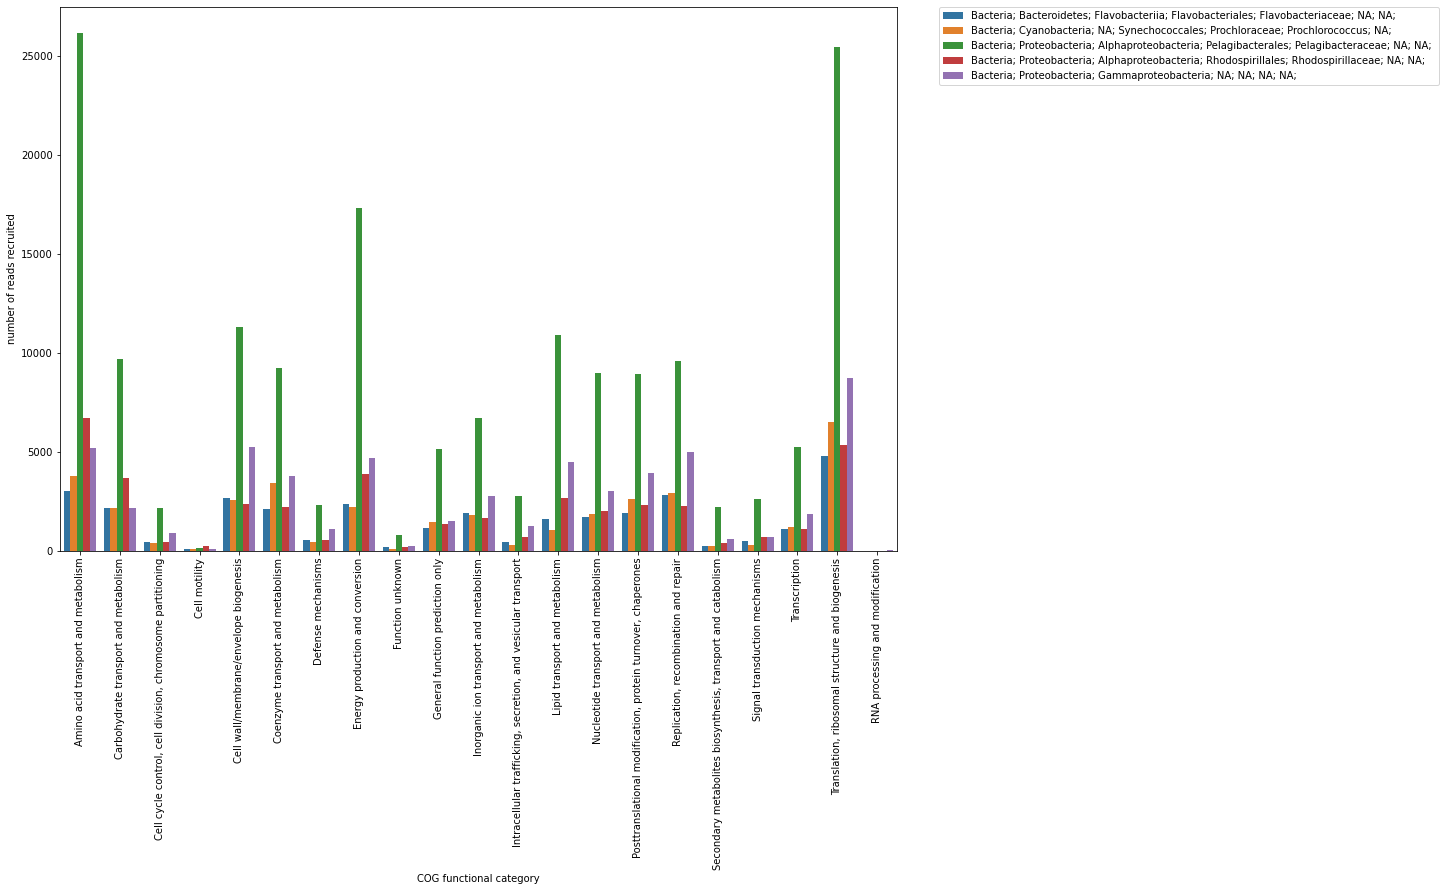

In [24]:
# set plot size
plt.rcParams['figure.figsize'] = [15, 10]

# and now to plot it
ax = sns.barplot(data= common_func_cat_df, x='Functional category description', y='number_of_reads', hue='taxonomic_lineage')

# generate labels
ax.set(xlabel = 'COG functional category',
       ylabel = 'number of reads recruited')


plt.xticks(rotation=90)

# move legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# save plot
plt.savefig(os.path.join(figdir,"COG_functional_categories.pdf"))

Alright this really does not tell us all that much since the Pelagibacteraceae have the most reads being recruited to a functional category for basically every single category because they are just so abundant in the ocean. Instead of looking at the total number of reads per category lets calculate the percent of reads that are mapping to each vcategory for each taxonomic lineage. This will give us some idea of differences in the genome structure and gene content of each lineage.

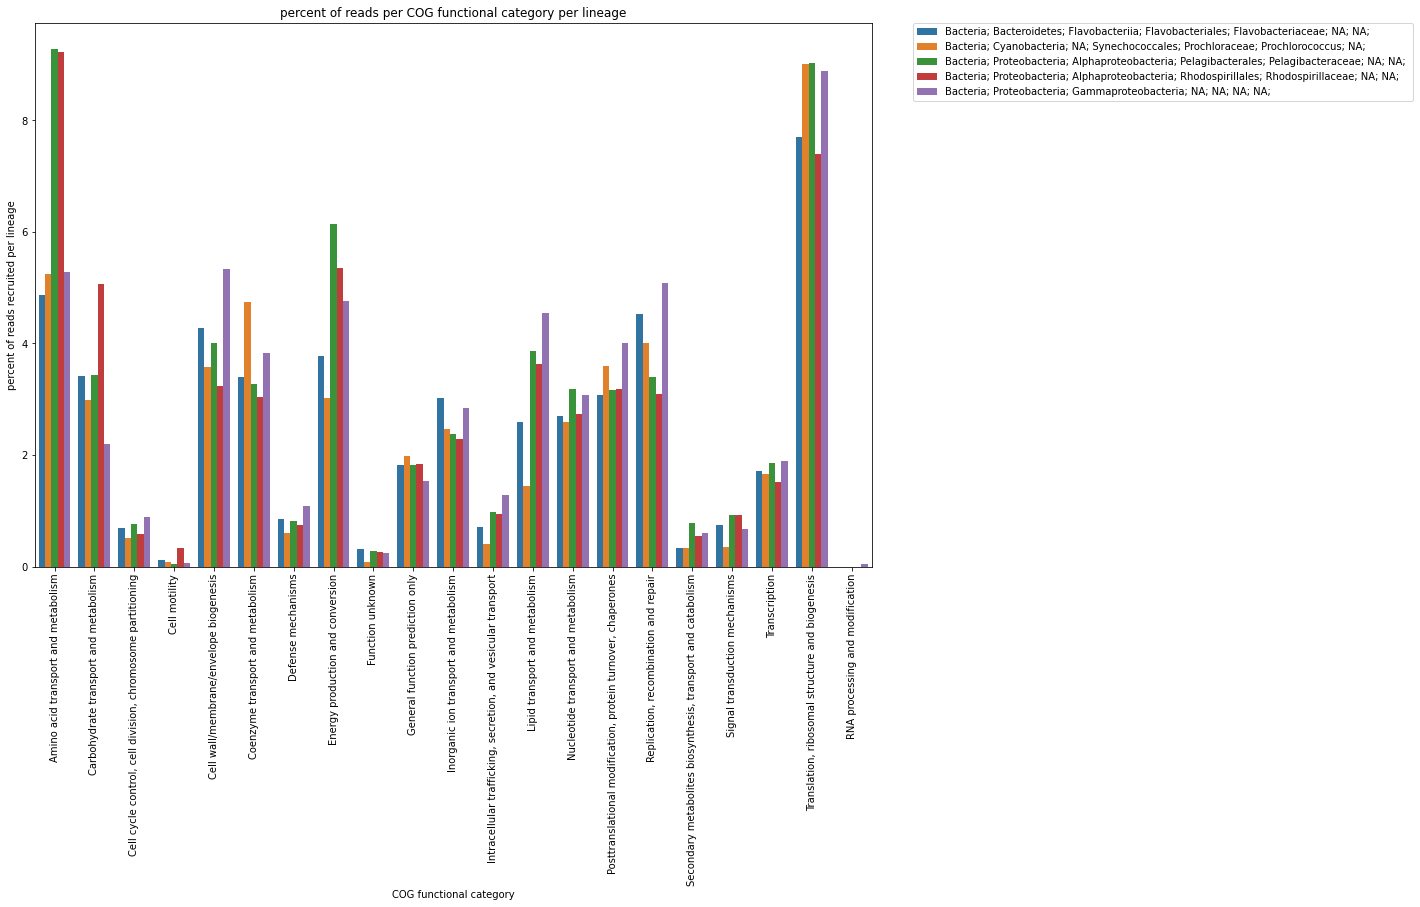

In [21]:

#sum the number of reads that were recruited to each tax lineage
total_reads=sub_tax_df[['taxonomic_lineage', 'number_of_reads']][:5].copy()
total_reads=total_reads.rename(columns={'number_of_reads':'total_number_of_reads'})

#merge the total number of reads with our dataframe and use it to calculate the percent of reads in each functional category
common_func_cat_df=common_func_cat_df.merge(total_reads, on='taxonomic_lineage')
common_func_cat_df['percent_of_tax_reads']=common_func_cat_df['number_of_reads']/common_func_cat_df['total_number_of_reads']*100


# create the barplot
sns.barplot(data= common_func_cat_df, x='Functional category description', y='percent_of_tax_reads', hue='taxonomic_lineage')

# generate labels
plt.xlabel('COG functional category')
plt.xticks(rotation=90)
plt.ylabel('percent of reads recruited per lineage')
plt.title('percent of reads per COG functional category per lineage')

# move legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# make it a bit bigger
plt.rcParams['figure.figsize'] = [15, 10]

# save plot
plt.savefig(os.path.join(figdir,"COG_functional_categories_percent.pdf"))


Now we can start to see some difference between the lienages. The Alphaproteobacteria lineages Pelagibacteraceae and Rhodospirillaceae seem to have a higher percentage of reads (fraction of genome) related to Amino acid transport and metabolism and Energy production and conversion than the other lineages, while the Gammaproteobacteria lineage have the highest fraction of reads recruited to Cell/wall and replication compared to other lineages

The cell below is entirely to demonstrate how to do this for multiple metagenomes, imagine that you have a time series and you want to compare abundance/functions across the time series. You can do this in a notebook and with pandas but it will quickly get out of hand.

In [25]:

# start timer to check how long this takes 
start = time.time()

# create an empty dataframe that we will populate in this cell
example_master_df=pd.DataFrame(columns=['taxonomic_lineage', 'prokka_product'])

# define the files that I want to summarize I am limiting it to ones where the number ends with a 2 to reduce time
# If I wanted to do it for all files it would be *.txt.gz
infiles=glob.glob('/mnt/storage/lesson_analyses/gorg-classifier/annotations/*2_annotated.txt.gz')
# loop through the files
for file in infiles:
    # extract the base name so that we can use it to rename the column with the metagenome name
    name=os.path.basename(file)
    name,ext=name.split('_')
    # read the file
    data=pd.read_csv(file, compression='gzip', sep='\t')
    # count the number of reads per taxonomic_lineage and product and rename the 
    counts=data[data['status']=='C'].groupby(['taxonomic_lineage', 'prokka_product'], as_index= False)['sequence_id'].count()
    counts=counts.rename(columns={'sequence_id':name})
    
    #merge the new dataframe with the master dataframe
    example_master_df=example_master_df.merge(counts, on=['taxonomic_lineage', 'prokka_product'], how='outer')
    
#timer end    
end = time.time()
print('it took', end - start, 'seconds to load 4 txt files, count the number of reads per function and lineage and \nmerge the counts for each metagenome into a single dataframe')

example_master_df

it took 20.650620937347412 seconds to load 4 txt files, count the number of reads per function and lineage and 
merge the counts for each metagenome into a single dataframe


,taxonomic_lineage,prokka_product,SRR5720332,SRR5720342,SRR5720262,SRR5720322
0,Archaea; Euryarchaeota; NA; NA; NA; NA; NA;,(6-4) photolyase,1.0,NaN,2.0,21.0
1,Archaea; Euryarchaeota; NA; NA; NA; NA; NA;,1-deoxy-D-xylulose-5-phosphate synthase,1.0,3.0,NaN,23.0
2,Archaea; Euryarchaeota; NA; NA; NA; NA; NA;,1-pyrroline-5-carboxylate dehydrogenase,2.0,5.0,NaN,27.0
3,Archaea; Euryarchaeota; NA; NA; NA; NA; NA;,15-cis-phytoene synthase,1.0,2.0,NaN,6.0
4,Archaea; Euryarchaeota; NA; NA; NA; NA; NA;,"2,C2-dialkylglycine decarboxylase",1.0,1.0,NaN,11.0
...,...,...,...,...,...,...
66299,NA; NA; NA; NA; NA; NA; NA;,"UDP-2,C3-diacetamido-2,C3-dideoxy-D-glucuronat...",NaN,NaN,NaN,2.0
66300,NA; NA; NA; NA; NA; NA; NA;,UDP-N-acetylglucosamine 4-epimerase,NaN,NaN,NaN,1.0
66301,NA; NA; NA; NA; NA; NA; NA;,Vitamin B12-dependent ribonucleoside-diphospha...,NaN,NaN,NaN,6.0
66302,NA; NA; NA; NA; NA; NA; NA;,putative type I restriction enzymeP M protein,NaN,NaN,NaN,1.0


In [26]:
example_master_df.to_csv(os.path.join(outdir,'example_master_metagenome_read_recruitment_summary.csv'))

So it took ~21 seconds to generate this df for 4 metagenomes where we recruited 1 million reads per metagenome. While it was doable for this course you can easily see how this would rapidly get out of hand if you tried to increase either 
1. the number of reads (1 billion+ read metagenomes are not uncommon) processing 1 billion reads from each of these four metagenomes would take ~10 hours
1. the number of metagenomes (Imagine you are comparing hundreds of metagenomes from different locations)

or both. 

In order to get around such issues we generally will write a script that will take care of doing the above summation and then once we have that we can just load this final dataframe into our notebook. 


## Further exploration ideas
1. What species has the most reads recruiting to Photosystem I? how about beta-xylanase? or some other gene you are intersted in?
1. What percent of reads recruit to Archaea compared to Bacteria? How about Alphaproteobacteria?
1. As you saw this morning summer metagenomes had higher recruitment to AG-910 than winter metagenomes. We started with a summer sample. Get a winter metagenome and compare  taxonomic and functional differences between the two.
     1. A winter metagenome SRR5720233
         - Hint think about how you are going to ensure that you can differentiate between the two metagenomes
     1. Metadata about other metagenomes can be found in this file (/mnt/storage/lessons/Day3PM_GORG-classifier/bats_metagenomes_of_interest.csv)
         
1. The first number of an EC number indicates the class of an enzyme. Use the EC number to look at the prevelance of different enzyme classes for a single species, between species, or between metagenomes
     - Hint the dictionary below contains the enzyme classes associated with the first digit of the EC number
```
            EC_nums={1: 'Oxidoreductase', 2 : "Transferases", 3 : "Hydrolases", 4 : "Lysases", 5 : "Isomerases", 6 : "Ligases", 7 : "Translocases"}
```

There are also lots of other columns that you can use to investigate these results. Consider using the KO numbers instead.